# DATA CLEANING

***

<br>

### Import Packages

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import re
import sys
sys.path.append('utils.pyutils.py')
import utils as utils
%matplotlib inline

##### We set the display option to see the full rows

In [2]:
pd.set_option('display.max_rows', 1500)

##### Read the csv file

In [3]:
df = pd.read_csv('./final_df.csv')

<br>

##### Let's see the first 5 rows 

In [4]:
df.head()

,Rank,University,Country,FTE_students,Staff_students,International_students_pct,Female_male_ratio,Overall,Teaching,Research,Citations,Industry_income,International_outlook
0,1,University of Oxford,United Kingdom,"20,664",11.2,41%,46 : 54,95.4,90.5,99.6,98.4,65.5,96.4
1,2,California Institute of Technology,United States,"2,240",6.4,30%,34 : 66,94.5,92.1,97.2,97.9,88.0,82.5
2,3,University of Cambridge,United Kingdom,"18,978",10.9,37%,47 : 53,94.4,91.4,98.7,95.8,59.3,95.0
3,4,Stanford University,United States,"16,135",7.3,23%,43 : 57,94.3,92.8,96.4,99.9,66.2,79.5
4,5,Massachusetts Institute of Technology,United States,"11,247",8.6,34%,39 : 61,93.6,90.5,92.4,99.5,86.9,89.0


<br>

<br>

##### I will change some column names so they'll be more human-readable

In [5]:
col_name = {'FTE_students':'No_FTE_students', 'Staff_students':'Students_per_staff'}
df.rename(columns = col_name,inplace = True)

<br>

##### Let's see the shape of our data

In [6]:
df.shape

(1397, 13)

<br>

##### now check the info of our columns 

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1397 entries, 0 to 1396
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Rank                        1397 non-null   object 
 1   University                  1397 non-null   object 
 2   Country                     1397 non-null   object 
 3   No_FTE_students             1397 non-null   object 
 4   Students_per_staff          1397 non-null   float64
 5   International_students_pct  1397 non-null   object 
 6   Female_male_ratio           1331 non-null   object 
 7   Overall                     1397 non-null   object 
 8   Teaching                    1397 non-null   float64
 9   Research                    1397 non-null   float64
 10  Citations                   1397 non-null   float64
 11  Industry_income             1397 non-null   float64
 12  International_outlook       1397 non-null   float64
dtypes: float64(6), object(7)
memory u

<br>

<br>

### Now let's do some formatting for our data before doing our analytics

---

##### Let's start with Rank column

<br>

##### There are some rows share the same rank, they will start with a '=' character, so let's delete them.


In [8]:
def format_Rank(string):
    if re.findall('\A=\d*',string):
        return string.split('=')[1]
    else:
        return string

In [9]:
df.Rank = df.Rank.apply(format_Rank)

In [10]:
#we strip the space in the rows by using strip() method

df.Rank = df.Rank.apply(lambda x: x.strip())

In [11]:
#the bins of ranking is not separate with equal ranges, so let's modify that.
#top 200 university's names are pure number, else they will have format like '601-800' or '1000+'

df.Rank = df.Rank.apply(lambda x: x if re.findall('.*[–+-].*',x) else '1–200')

df.Rank = df.Rank.apply(lambda x:'401-600' if x in ['401–500','501–600'] else x)

df.Rank = df.Rank.apply(lambda x: '201-400' if x in ['201–250','251–300','301–350','351–400'] else x)

df.replace({'1001+':1,'801–1000':2, '601–800':3,'401-600':4,'201-400':5,'1–200':6},inplace=True)

<br>

In [12]:
df.Rank.value_counts()

1    396
6    202
3    202
4    200
5    199
2    198
Name: Rank, dtype: int64

<br>

<br>

##### No_FTE_students column

In [13]:
#because the data type of this column is object that includes comma, so to convert them to integer, we'll need to remove those commas

df.No_FTE_students = df.No_FTE_students.apply(lambda x: x.replace(',','')).astype('int')

<br>

<br>

##### International_students_pct column

In [14]:
#This column also have the data type of object, so we will need to remove the % character
df.International_students_pct = df.International_students_pct.apply(lambda x: x.split('%')[0])
df.International_students_pct = df.International_students_pct.apply(lambda x: x.strip())

#there is some rows with nan values, more specific here it's ' ' values, so we need to strip those and replace them with 0
#also because we have just 2 observations that're nan values, so we can feel satisfy filling them with 0
df.International_students_pct.replace('', 0, inplace = True)

#convert to float data type
df.International_students_pct = df.International_students_pct.astype('float')

<br>

<br>

##### Female_male_ratio column

In [15]:
#our dataframe has 1397 rows, but this column only have 1331 rows. There must be some missing rows.
df.Female_male_ratio.value_counts().sum()

1331

In [16]:
#we have a value of 100:0, so we will replace it for compute purpose 
df.Female_male_ratio = df.Female_male_ratio.replace('100 : 0', '100 : 1')

#we will fill the missing rows with this just for now
df.Female_male_ratio = df.Female_male_ratio.fillna('0 : 1')

In [17]:
#now we have the full rows 
df.Female_male_ratio.value_counts().sum()

1397

In [18]:
#I'll create 2 new columns from the original Female_male_ratio column to calculate the exactly number

df.loc[:,'numerator'] = df.Female_male_ratio.apply(lambda x: int(str(x).split(':')[0].strip()))

df.loc[:,'denominator'] = df.Female_male_ratio.apply(lambda x: int(str(x).split(':')[1].strip()))

df.loc[:,"Female_male_ratio"] = df['numerator'] / (df['numerator'] + df['denominator'])

In [19]:
#now we can drop those 2 columns

df.drop(['numerator','denominator'], axis = 1, inplace = True)

In [20]:
#we will create value for those university that we don't have Female_male_ratio using their country's mean ratio
#first create a data where we don't have unknown ratio

no_zero_df = df[df.Female_male_ratio != 0]


#create a dictionary to store country's mean ratios using group by aggregation

no_zero_dict = dict(no_zero_df.groupby('Country')['Female_male_ratio'].agg('mean'))


#now we just have to fill out unknown ratios with the values we've calculated using map method

df.loc[df.Female_male_ratio == 0,'Female_male_ratio'] = df.loc[df.Female_male_ratio == 0, 'Country'].map(no_zero_dict)



In [21]:
#convert the ratio to pct
df.Female_male_ratio = df.Female_male_ratio.round(4)*100

#rename column
df.rename(columns = {'Female_male_ratio':'Female_pct'}, inplace = True)

<br>

<br>

##### Overall column

In [22]:
#In the Overall column, we have some range values, i decided to replace those ranges with their mean so we can use some statistics here.
Overall_mapping = {'10.7–22.1' : np.mean([10.7,22.1]),
                  '28.3–35.2' : np.mean([28.3,35.2]),
                   '22.2–28.2': np.mean([22.2,28.2]),
                   '38.8–42.3': np.mean([38.8,42.3]),
                   '35.3–38.7': np.mean([35.3,38.7]),
                  '42.4–44.4': np.mean([42.4,44.4]),
                   '46.9–50.0': np.mean([46.9,50.0]),
                   '44.5–46.8': np.mean([44.5,46.8]),
                   '50.1–53.7': np.mean([50.1,53.7])
                  }

In [23]:
df.Overall = df.Overall.replace(Overall_mapping)


#We convert the column to float type
df.Overall = df.Overall.astype('float')

<br>

<br>

##### Check for duplicated rows

In [24]:
df.duplicated().sum()

0

<br>

##### Now, let's see some data's statistics after cleaning.

In [25]:
utils.unistats(df)

,Count,Missing,Unique,Dtype,Numeric,Mode,Mean,Min,25%,Median,75%,Max,Std,Skew,Kurt
Students_per_staff,1397,0,372,float64,True,12.5,19.012,0.9,12.4,16.4,21.9,493.5,16.9137,16.7769,447.587
No_FTE_students,1397,0,1378,int32,True,1142,23741.2,558,10267,17848,29437,830104,32821.3,13.4718,284.815
Teaching,1397,0,424,float64,True,16.7,28.2218,11.2,18.3,23.8,33.6,92.8,14.1471,1.89942,4.29779
International_students_pct,1397,0,62,float64,True,1,11.3414,0,2,8,17,83,11.7732,1.8242,4.86263
Research,1397,0,466,float64,True,10,23.9704,6.8,11.6,18,30.1,99.6,17.5354,1.81935,3.51441
Industry_income,1397,0,379,float64,True,34.4,46.4694,34.4,35.7,39.4,49.8,100,16.2703,1.81385,2.46152
Overall,1397,0,145,float64,True,16.4,34.5883,16.4,16.4,31.75,45.65,95.4,17.0819,0.945962,0.609038
International_outlook,1397,0,653,float64,True,21.5,47.0989,13.1,27.4,43.1,62.8,99.7,23.2877,0.555953,-0.734546
Citations,1397,0,742,float64,True,23.6,48.0915,1.7,23.3,45.5,71.9,100,27.7375,0.217731,-1.17061
Rank,1397,0,6,int64,True,1,3.15319,1,1,3,5,6,1.80798,0.21581,-1.35368


<br>

##### we see some skewness issues here. Let's plot them using histogram

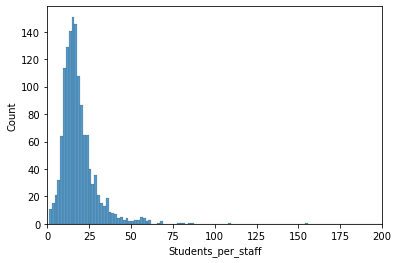

In [26]:
sns.histplot(data = df, x="Students_per_staff")
plt.xlim(0,200)
plt.show()

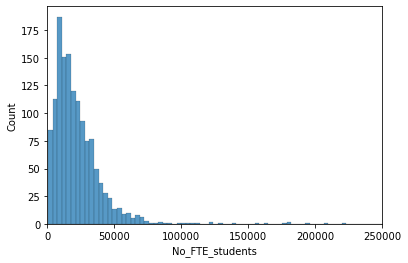

In [27]:
sns.histplot(data =df, x="No_FTE_students")
plt.xlim(0,250000)
plt.show()

<br>

##### We will handle outliers

In [28]:
def remove_outliers(df, col):
    q25, q75 = df[col].quantile(0.25), df[col].quantile(0.75)
    iqr = q75 - q25
    cut_off = iqr * 1.5
    lower, upper = q25 - cut_off, q75 + cut_off
    outliers = [x for x in df[col] if x < lower or x > upper]
    outliers_removed = [x for x in df[col] if x>lower and x<upper]
    df = df[df[col].isin(outliers_removed)]
    return df

In [29]:
df = remove_outliers(df,'No_FTE_students')

In [30]:
df = remove_outliers(df, 'Students_per_staff')

In [31]:
df.shape

(1262, 13)

<br>

##### Check our data again 

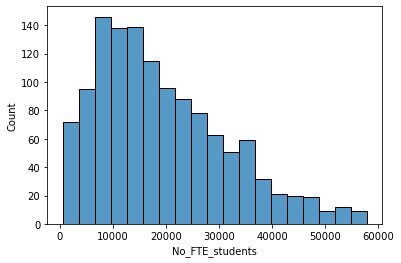

In [32]:
sns.histplot(data = df, x = 'No_FTE_students');

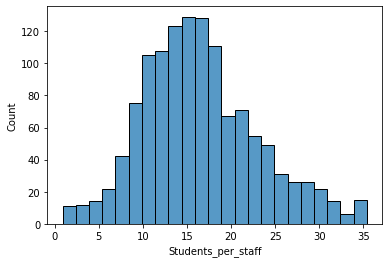

In [33]:
sns.histplot(data = df, x = 'Students_per_staff');

In [34]:
utils.unistats(df)

,Count,Missing,Unique,Dtype,Numeric,Mode,Mean,Min,25%,Median,75%,Max,Std,Skew,Kurt
Teaching,1262,0,403,float64,True,16.7,28.2172,11.2,18.6,23.9,33.1,92.8,14.1592,2.00017,4.7343
Research,1262,0,438,float64,True,10,23.7689,6.8,11.7,17.85,29.6,99.6,17.4275,1.92932,4.01225
Industry_income,1262,0,361,float64,True,34.4,46.341,34.4,35.8,39.4,49,100,16.1094,1.82866,2.52136
International_students_pct,1262,0,62,float64,True,1,11.5174,0,2,8,17,83,12.0209,1.82735,4.79291
Overall,1262,0,131,float64,True,16.4,34.4403,16.4,16.4,31.75,43.4,95.4,17.0466,1.00475,0.802946
No_FTE_students,1262,0,1244,int32,True,1142,19283.8,558,9723.75,16651,26824.2,57827,12291.8,0.800028,0.103364
International_outlook,1262,0,621,float64,True,21.5,46.9918,13.1,26.625,42.4,63.575,99.7,23.7435,0.560421,-0.786661
Students_per_staff,1262,0,286,float64,True,12.5,16.4313,0.9,11.9,15.7,20.275,35.4,6.5248,0.484978,0.136302
Citations,1262,0,711,float64,True,20.7,47.8738,1.7,23.3,44.8,71.875,100,27.8524,0.241185,-1.15426
Rank,1262,0,6,int64,True,1,3.13154,1,1,3,5,6,1.78862,0.227257,-1.33087


<br>

##### Now our data is ready.

<br>

---

### Save the dataframe to csv format

In [35]:
df.to_csv('clean_data.csv',index = False)